## Experiment tracking using Neptune and MLflow

In [1]:
#import base libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import serializer
import pickle

In [3]:
# import neptune libraries and sklearn integration
import neptune.new as neptune
import neptune.new.integrations.sklearn as npt_skl

In [4]:
# import mlflow and libraries
import mlflow
import mlflow.sklearn

### Experiment tracking with Neptune

In [5]:
run = neptune.init(
    project="alessandro.cubeddu/omdena-mlops-solar",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZTRjYjkzNy0wODlhLTQyZmQtODdjYS1kMWM2YzQ1NTY0OTUifQ==",
    name='solar-irradiation',
    source_files=['model_dev_val_export_solar_radiation.ipynb']
)  # your credentials

https://app.neptune.ai/alessandro.cubeddu/omdena-mlops-solar/e/OM-4


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


#### Track files, models and folders

In [6]:
# tracking files
run["cleaned_datasets"].track_files("../datasets/cleaned/")
run["raw_datasets"].track_files("../datasets/raw/")

# tracking folders
run["notebooks"].track_files("../notebooks/")

#### train and test models while tracking the experiment

In [7]:
# load models
pipeline_lr = pickle.load(open("../bin/models/lr_model.pkl", "rb"))
pipeline_rf = pickle.load(open("../bin/models/rf_model.pkl", "rb"))
pipeline_gbr = pickle.load(open("../bin/models/gbr_model.pkl", "rb"))

In [8]:
# load splitted data
with open("../bin/var/splitted_data.pkl", "rb") as data:
    data_list = pickle.load(data)

In [9]:
X_train = data_list[0]
y_train = data_list[1]
X_test = data_list[2]
y_test = data_list[3]
X_val = data_list[4]
y_val = data_list[5]

In [10]:
for d in data_list:
    print(d.shape)

(591, 10)
(591,)
(127, 10)
(127,)
(127, 10)
(127,)


Did not log feature importance chart. Error: could not find feature importances param on Pipeline
Did not log feature importance chart. Error: could not find feature importances param on Pipeline
Did not log feature importance chart. Error: could not find feature importances param on Pipeline


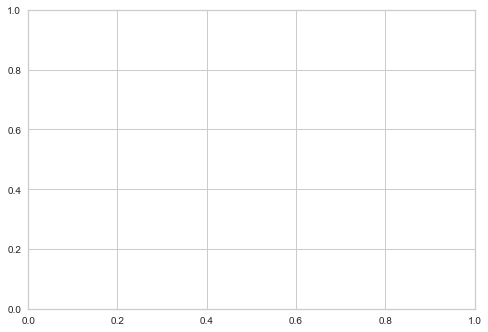

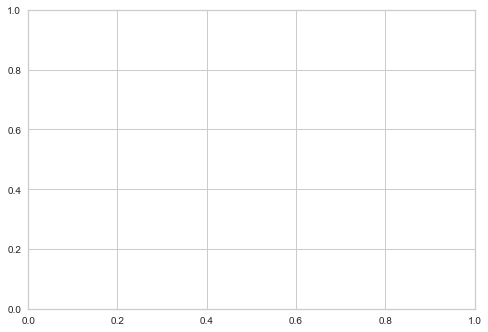

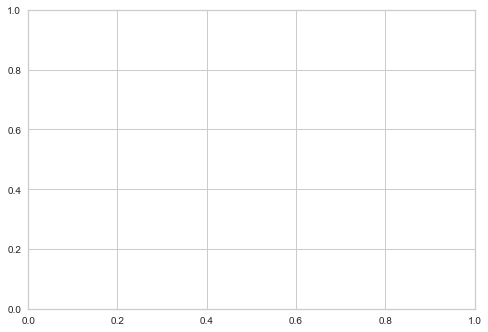

In [11]:
run['lr_summary'] = npt_skl.create_regressor_summary(pipeline_lr, X_train, X_test, y_train, y_test)

run['rf_summary'] = npt_skl.create_regressor_summary(pipeline_rf, X_train, X_test, y_train, y_test)

run['gbr_summary'] = npt_skl.create_regressor_summary(pipeline_gbr, X_train, X_test, y_train, y_test)

#### stop experiment

In [12]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 55 operations to synchronize with Neptune. Do not kill this process.


All 55 operations synced, thanks for waiting!
